# Encuesta Nacional de Nutrición y Salud (ENNyS2)

## Introducción

La Segunda Encuesta Nacional de Nutrición y Salud (ENNyS 2) fue realizada en Argentina entre octubre de 2018 y febrero de 2019 por el Ministerio de Salud.

Su objetivo es describir la situación alimentaria y de salud de la población, recolectando información sobre:

* Consumo de alimentos y bebidas (recordatorio de 24 horas, frecuencia y tipo de alimentos).

* Estado nutricional (mediciones antropométricas y composición corporal).

* Enfermedades crónicas y factores de riesgo (hipertensión, diabetes, colesterol alto, etc.).

* Condiciones sociodemográficas y del hogar (cobertura de salud, nivel educativo, ingresos, etc.).

* Hábitos de vida (actividad física, lactancia, consumo de tabaco y alcohol, etc.).

El diseño muestral es probabilístico, estratificado y multietápico, lo que asegura representatividad nacional y por regiones.

## Cuestionarios por grupo etario

C1: Niños/as de 0 a 23 meses.

C2: Niños/as de 2 a 12 años.

C3: Adolescentes de 13 a 17 años.

C4: Adultos de 18 años o más.

En este trabajo utilizamos la base principal publicada en el portal de datos abiertos del Ministerio de Salud, junto con las bases complementarias de alimentos y nutrientes.

---


# Estructura de las base de la ENNyS2

La base principal tiene 1830 columnas, organizadas en módulos y prefijos que identifican tipo de dato, población objetivo y, en algunos casos, la posición del miembro del hogar.


### Convenciones de nombres:

C1_ / C2_ / C3_ / C4_: Variables de cuestionarios específicos según grupo etario.

T_Cn_*: Variables totales o derivadas de un módulo.
Ejemplo: T_C4_ActFisTotal (total de minutos de actividad física en adultos).

I_d_Cn_*: Indicadores por día dentro del módulo.
Ejemplo: I_1_C4_Kcal I_2_C4_Kcal si hubiera segundo día.

Mn_*: Información de miembros del hogar (hasta 15 posibles).
Ejemplo: M01_Edad, M02_Sexo, M02_Parentesco, M1_NivelEdu

SD_*: bloque Sociodemográfico (hogar/vivienda/listado de miembros).
T_SD_*: transformaciones/derivados del sociodemográfico (totales, tramos, flags).

FCA_*: Frecuencia de Consumo de Alimentos.

HAC_*: Hábitos y Conductas (alimentarias/actividad/sueño/adicciones).

F_*: factores/ponderadores u otros factores específicos.

EE_*: estados/estudios.


## Campos estructurales (para poder vincular bases)

region: identifica area geografica (GBA, Centro, NOA, etc)

id: identificador ÚNICO para cada entrevista realizada. Clave primaria a nivel base.

UPM: Bloque de viviendas seleccionadas en la muestra. Se repite para todas las viviendas dentro de ese segmento.

vivienda_id: identificador único de la vivienda. Identifica un espacio fisico (casa, departamento, etc).

hogar_id: Contador de hogar dentro de la vivienda (1, 2, 3,...). En una misma vivienda pueden convivir varios hogares (dos familias distintas en el mismo departamento).

miembro_id: Contador de persona dentro del hogar (1, 2, 3,...). Siempre se usa junto a hogar_id y vivienda_id.

E_CUEST: Cuestionario aplicado.

ES_Seleccionado: indicador de cuál miembro fue sorteado para responder.


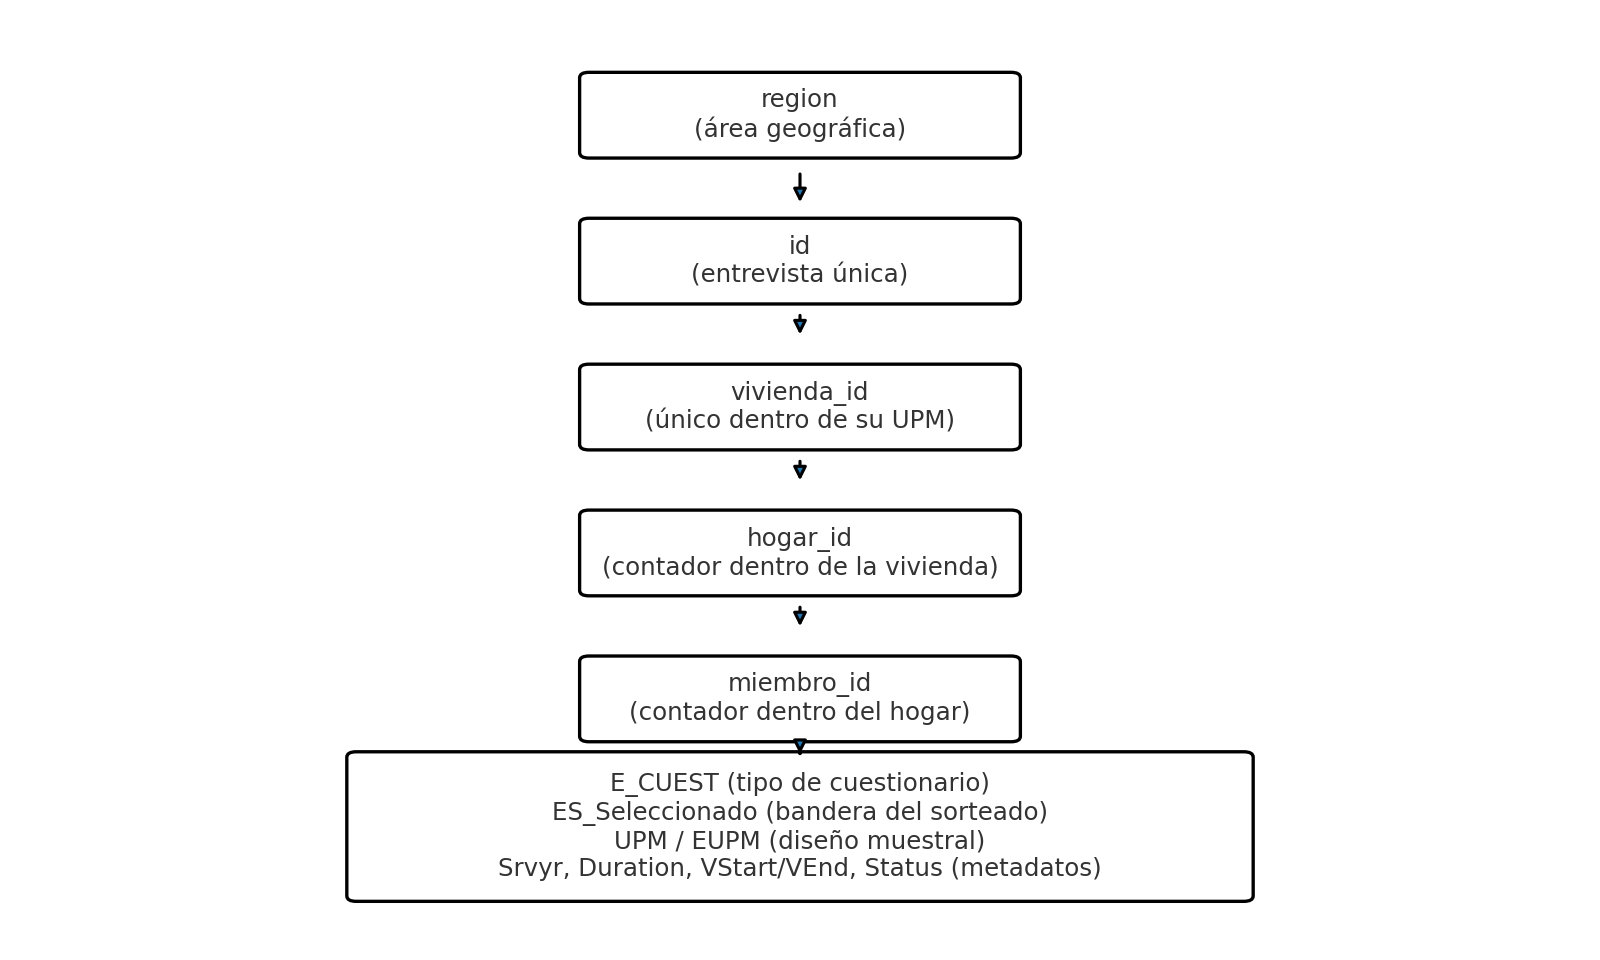

---

## Columnas MXX_

Cada registro de la base de la encuesta corresponde a una entrevista realizada en un hogar. Esa entrevista tiene dos etapas de información:

* 1. Etapa de hogar/familia: se listan todos los convivientes y se relevan variables de vivienda, ingreso, alimentacion, parentesco, etc. Esta parte se encuentra en las columnas MXX_ que contienen datos de varios miembros. Es una tabla aplanada en columnas.

* 2. Etapa de individuo seleccionado: Se aplica un unico cuestionario seleccionado. De esta persona tenemos información profunda: salud, antropometría, recordatorio 24h, etc.

---

# Cómo se realiza la encuesta

## 1. Formulario sociodemográfico (hogar e individuos)

* Todos los hogares seleccionados responden un formulario básico.

* Ahí se registran todos los integrantes: edad, sexo, parentesco, educación, variables socioeconómicas, etc.

* Esa es la información mínima, los llamados microdatos básicos.

## 2. Sorteo del individuo

* De cada hogar se elige un integrante al azar.

* Ese es el único que responde el cuestionario individual completo según su edad:

    * C1 → 0 a 23 meses

    * C2 → 2 a 12 años

    * C3 → 13 a 17 años

    * C4 → 18 años y más

**Importante**: solo el seleccionado tiene datos completos de salud, alimentación, antecedentes, etc.

## 3. Recordatorio de 24 horas (R24H)

* También se aplica solo al seleccionado.

* Registra todo lo consumido el día anterior (alimentos, bebidas, cantidades, horarios, contexto).

* En algunos casos se hace un segundo R24H en otro día, para captar variabilidad.

* Si no puede responder (bebés → se entrevista al adulto responsable, rechazos, etc.), el registro queda faltante.

* Estos datos se guardan en bases específicas:

    * Base de alimentos: cada fila es un alimento consumido.

    * Base de nutrientes: desglose de energía y nutrientes de esos alimentos.

## 4. Quienes no fueron sorteados

* El resto de los integrantes del hogar solo tienen los datos sociodemográficos básicos.

* No tienen cuestionario C1–C4 ni recordatorio de 24 hs.

---

## Procedimiento para realizar el analisis

1. Separar las columnas MX_ en una base aparte, en formato largo (cada fila = un conviviente).

2. Filtrar a los seleccionados (ES_Seleccionado = "Si").

3. Dividir en grupos etarios (C1–C4).

4. Analizar variables de interés (ej. socioeconómicas, consumo, estado nutricional).

---
## Aclaración sobre la cantidad de seleccionados

Aunque el diseño planteaba que en cada hogar un miembro fuera encuestado de manera completa, en la práctica solo una fracción logró llegar a esa etapa.

De los más de 21.000 hogares/entrevistas efectivas, alrededor de 5.500 individuos aparecen con cuestionario completo. El resto aportó información sociodemográfica y de vivienda, pero no llegó a completar el módulo individual.

### Las razones son principalmente operativas:

Rechazo de la persona seleccionada a responder el cuestionario largo, a la antropometría o a las muestras biológicas.

Problemas logísticos en campo (disponibilidad de encuestadores especializados, equipamiento, traslados de muestras).

Diseño en submuestras para ciertas mediciones más costosas (bioquímica, orina, sangre).

Conclusión: No se trata de un error en la base, sino de la diferencia entre la intención del diseño (1 seleccionado por hogar) y la realidad del operativo (no siempre se logró completarlo). Por eso, en los análisis nutricionales y de consumo solo pueden usarse esos 5.500 casos.

---

## 1. Creamos una base sin la columnas MX_ y una base con las columnas MX_

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import re

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

# Cargar base de la encuesta
DATA = Path("../data")  # tu carpeta de datos
FILE = DATA / "ENNyS2_encuesta.csv"

df = pd.read_csv(FILE, encoding="utf-8-sig", low_memory=False)
print("Base original:", df.shape)


# Identificadores que se deben conservar en ambas tablas
id_cols = ["ES_Seleccionado", "miembro_id", "hogar_id", "vivienda_id", "region"]

# Selección exacta de columnas de miembros: M00_ .. M15_
pat = re.compile(r"^M(0[0-9]|1[0-5])_")
m_cols = [c for c in df.columns if pat.match(c)]

print("Columnas M00_..M15_ detectadas:", len(m_cols))

# Base sin columnas
df_sin_m = df.drop(columns=m_cols, errors="ignore").copy()

# Base solo con columnas Mxx + IDs 
df_solo_m = df[id_cols + m_cols].copy()

print("ENNyS2_sin_M:", df_sin_m.shape)
print("ENNyS2_solo_M:", df_solo_m.shape)

Base original: (21358, 1830)
Columnas M00_..M15_ detectadas: 510
ENNyS2_sin_M: (21358, 1320)
ENNyS2_solo_M: (21358, 515)


# 2. Reformateamos la tabla de ancho a largo

In [2]:
# columnas MX_
m_cols = [c for c in df_solo_m.columns if c not in id_cols]

# 2) wide -> long
m_long = df_solo_m.melt(
    id_vars=id_cols,
    value_vars=m_cols,
    var_name="col",      # ej: "M03_Edad"
    value_name="valor"
)

# 3) separar miembro y nombre de variable: "M03_Edad" -> miembro="03", variable="Edad"
ext = m_long["col"].str.extract(r"^M(?P<miembro>\d{2})_(?P<variable>.+)$")
m_long = pd.concat([m_long[id_cols], ext, m_long["valor"]], axis=1)

# ordenar / limpiar
m_long["miembro"] = m_long["miembro"].astype(str).str.zfill(2)
m_long = m_long.dropna(subset=["miembro", "variable"])  # descarta cualquier col rara
m_long = m_long[ id_cols + ["miembro", "variable", "valor"] ] \
             .sort_values(id_cols + ["miembro", "variable"]) \
             .reset_index(drop=True)

print("m_long (filas, columnas):", m_long.shape)
m_long.head(10)


m_long (filas, columnas): (10892580, 8)


,ES_Seleccionado,miembro_id,hogar_id,vivienda_id,region,miembro,variable,valor
0,,248951,90687,209377,Centro,01,SD_10,No
1,,248951,90687,209377,Centro,01,SD_11,
2,,248951,90687,209377,Centro,01,SD_12,Argentina
3,,248951,90687,209377,Centro,01,SD_14_O1,No tiene ninguna
4,,248951,90687,209377,Centro,01,SD_14_O2,
5,,248951,90687,209377,Centro,01,SD_14_O3,
6,,248951,90687,209377,Centro,01,SD_14_O4,
7,,248951,90687,209377,Centro,01,SD_14_O5,
8,,248951,90687,209377,Centro,01,SD_14_O6,
9,,248951,90687,209377,Centro,01,SD_14_O7,



## 3. Separamos las 4 subbases (C1 a C4) en df_sin_m

In [3]:
df_sel = df_sin_m[df_sin_m["ES_Seleccionado"]=="Si"]

c1 = df_sel[df_sel["E_CUEST"]=="0 a 23 meses"]
c2 = df_sel[df_sel["E_CUEST"]=="2 a 12 años"]
c3 = df_sel[df_sel["E_CUEST"]=="13 a 17 años"]
c4 = df_sel[df_sel["E_CUEST"]=="18 o mas años"]

print("Seleccionados:", df_sel.shape[0])
print("0 a 23 meses:", c1.shape[0])
print("2 a 12 años:", c2.shape[0])
print("13 a 17 años:", c3.shape[0])
print("18 años y más:", c4.shape[0])

Seleccionados: 5506
0 a 23 meses: 2013
2 a 12 años: 216
13 a 17 años: 401
18 años y más: 2876


## 4. Guardamos los resultados

In [4]:
# --- Guardar ---
OUT = DATA / "processed"
OUT.mkdir(parents=True, exist_ok=True)
df_sin_m.to_csv(OUT / "ENNyS2_sin_M.csv", index=False)
df_solo_m.to_csv(OUT / "ENNyS2_solo_M.csv", index=False)
c1.to_csv(OUT / "ENNyS2_c1.csv", index=False)
c2.to_csv(OUT / "ENNyS2_c2.csv", index=False)
c3.to_csv(OUT / "ENNyS2_c3.csv", index=False)
c4.to_csv(OUT / "ENNyS2_c4.csv", index=False)


---

## 3. Cargamos base de alimentos

In [4]:
FILE = DATA / "Base_Alimentos_Bebidas_Suplementos.csv"

alimentos = pd.read_csv(FILE, encoding="utf-8-sig", low_memory=False) # Encoding para acentos

alimentos.shape

(26028, 1114)